# Overview
In this notebook we will be using Keras to build and train a Convolutional Neural Network (CNN) to be able to classify images of clothing.  The model will be trained using the Fashion MNIST dataset.  The trained model will be exported to a .tflite format, and deployed in an web API.

The following steps will be followed:
1. Load the Data
1. Perform Exploratory Data Analysis (EDA)
2. Prepare the Data
3. Machine Learning
4. Analyze Performance
5. Export the Model

We will set a random seed, so that the results of this notebook are repeatable

In [1]:
SEED = 211
import os
import random as rn
import numpy as np
import tensorflow as tf
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

Then load the remaining libraries that we will use

In [2]:
import pandas as pd
from visualkeras import layered_view
from tensorflow.keras import layers, models, utils, optimizers
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from skimage.util import random_noise
from PIL.ImageOps import invert
from PIL import Image

# Load Data
We will start by loading the data into a Pandas dataframe.  Pandas will be useful to explore the data.
<br> The data has already been split for us into a training and testing set.  The training set will be used to train the model, and the testing set will be used to test the accuracy of the model on data it was not trained on.

In [3]:
train = pd.read_csv('data/fashion-mnist_train.csv')
test = pd.read_csv('data/fashion-mnist_test.csv')

The dataset is labeled using integers between 0 and 9 indicating the type of item in the image.  We will create a dictionary to use to translate the integer labels into human readable text.

In [4]:
labels = [
    'T-shirt/top',  # 0
    'Trouser',      # 1
    'Pullover',     # 2
    'Dress',        # 3
    'Coat',         # 4
    'Sandal',       # 5
    'Shirt',        # 6
    'Sneaker',      # 7
    'Bag',          # 8
    'Ankle boot'    # 9
    ]

# Exploratory Data Analysis
First we'll start by looking at the head of the data.
<br>Each row in the data represents a 28 x 28 image, with its pixels flattened to a single row.
<br>The labels correspond to the type of item shown in the image.

In [5]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The training data contains 60,000 examples, each with a label, and 784 pixel values.  The original images were square, so the actual images are 28 by 28.

In [6]:
train.shape

(60000, 785)

Lets take a look at some of the images, by changing their shape back to the original 28 x 28.
- The images are grey-scale.
- White is represented by a 0, and black is represented by a 255.  We'll need to make note of this because this is the inverse of normal images, so we'll need to account for that if we want to provide the model with real world data to classify in the future.
- The images are cropped such that there is no space between the edge of the picture, and the object.  Real world data may not be cropped so cleanly, so we'll want to also make note of this for training 

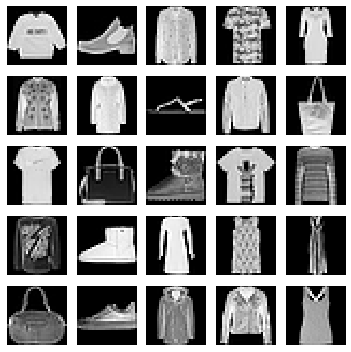

In [7]:
rows = 5
columns = 5

images = np.array(train[:rows*columns].drop(columns=['label']))
images = np.reshape(images, (images.shape[0], 28,28))


fig, axs = plt.subplots(rows,columns, figsize=(5, 5))
indx = 0
for i in range(rows):
    for j in range(columns):
        axs[i,j].imshow(images[indx], interpolation='nearest', cmap='gray')
        axs[i,j].axis('off')
        label = labels[train[:rows*columns]['label'][indx]]
        # axs[i,j].title.set_text(f'Label: {label}')
        indx += 1
plt.tight_layout()
plt.show()

We'll check the frequency of each label in the training data.  A balanced dataset will have similar amounts of each type of label, this helps the network to not favour one label over another when training.
<br> The data set is balanced with 6000 examples for each label.

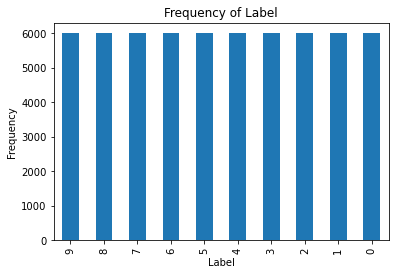

In [8]:
ax = train['label'].value_counts().plot(kind='bar', title='Frequency of Label')
x = ax.set_xlabel('Label')
y = ax.set_ylabel('Frequency')

We can think of each column in data (784 pixels + 1 label) as a dimension.  It is impossible to plot 785 dimensions, but we can use a tool called principal component analysis to squish the data into lower dimensional space.
<br>We will use this to flatten the data into 3 dimensions so we can take a better look.
- Bags intersect with a lot of other types of data, it could prove challenging for the CNN
- Footwear (Ankle Boots, Sandals, and Sneakers) seems to cluster together.
- Cloths that go on the torso (T-Shirt/top, Pullover, Coat, Dress) cluster together.
- Dresses and Trousers cluster together

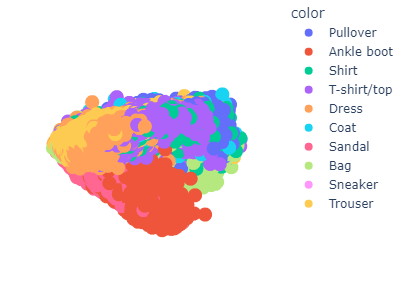

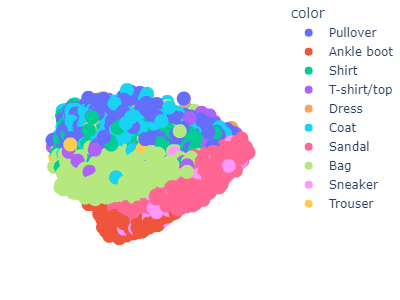

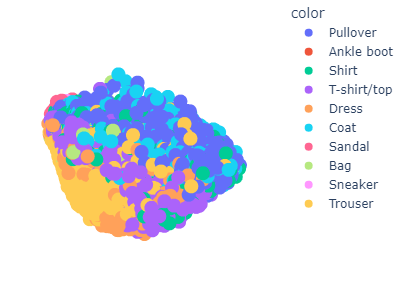

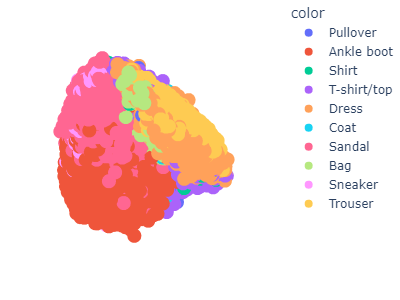

In [9]:
# Reduce to 3 dimensions
pca = PCA(n_components=3)
components = pca.fit_transform(train.drop(columns=['label']))

# Load data into figure
fig = px.scatter_3d(components, x=0, y=1, z=2, labels=labels, color=[labels[l] for l in train['label']])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), width=400, height=300)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False)

# Helper function to adjust camera angle
def show(fig, x=1.25, y=1.25, z=1.25):
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=x, y=-y, z=-z)
        )
    fig.update_layout(scene_camera=camera)
    fig.show(renderer = "png")

# fig.show() # interactive for someone who runs notebook locally
# rotate camera for multiple angles since github doesn't support interactive chart
show(fig)
show(fig, x=-1.25, y=-1.25, z=-1.25)
show(fig, x=1.25, y=1.25, z=-1.25)
show(fig, x=-1.25, y=1.25, z=1.25)


# Prepare Data

### Separate labels and data
The labels and the data are all in one array.  We'll start by splitting these into two separate parts.
We'll also convert everything into a Numpy array as it will be easier to use this data format in the next steps.

In [10]:
X_train = np.array(train.drop(columns=['label']))
X_test = np.array(test.drop(columns=['label']))

y_train = np.array(train['label'])
y_test = np.array(test['label'])

### Normalize
We are planning to train a convocational neural network (CNN) on this data, when training a CNN, they can learn faster if the values of the data are between 0 and 1.
- We will first subtract every pixel value by the lowest value pixel, making the brightest part of the image white
- Then we will divide every pixel value by the highest value pixel, making all pixels be in a range of 0 and 1

In [11]:
X_train.min().min(), X_train.max().max()

(0, 255)

In [12]:
def normalize(X: np.array):
    X = X.T - X.min(axis = 1) # maximize contrast
    X = X.T / X.max(axis = 1) # normalize values to be between 0 and 1
    return X

In [13]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [14]:
X_train.min().min(), X_train.max().max()

(0.0, 1.0)

### Reshape
CNN's use the position of the data in the array to learn with context so we will reshape the data to be a two-dimensional pixel array with one color channel (28 x 28 x 1). 
<br> We will be using a Softmax layer for output.  Softmax is useful because it will give us the confidence the network has for its prediction.  To use softmax, the targets must be categorical using one hot encoding.
- 0 becomes [1,0,0,0,0,0,0,0,0,0]
- 1 becomes [0,1,0,0,0,0,0,0,0,0]
- 2 becomes [0,0,1,0,0,0,0,0,0,0]
- and so on

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], 28,28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28,28, 1))

y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [16]:
X_train.shape

(60000, 28, 28, 1)

In [17]:
y_train.shape

(60000, 10)

### Augment
As noted in the EDA, training images are perfectly cropped. We will augment the training data
1. Creating copies of each image, and scaling them down so there are examples with some padding, tripling our training data
2. Duplicate all the training images and mirror them, doubling our training data
3. We will then add noise to the images, simulating more realistic examples for what we will expect from the real world

After this, we will have a training set of 6x our original dataset

In [18]:
def augment(X, y):
    """Generate more training data by creating different sized images."""
    X_new = X
    y_new = y
    scales = [21, 18]
    for scale in scales:
        new = tf.image.resize(X, [scale, scale])
        new = tf.image.resize_with_crop_or_pad(new, 28, 28)
        X_new = np.append(X_new, new, axis = 0)
        y_new = np.append(y_new, y, axis = 0)

    X_new = np.append(X_new, np.flip(X_new, axis=2), axis = 0)
    X_new = random_noise(X_new, seed = SEED)
    y_new = np.append(y_new, y_new, axis = 0)

    return X_new, y_new

In [19]:
X_train, y_train = augment(X_train, y_train)
X_test, y_test = augment(X_test, y_test)

Examples of scaled down images with noise

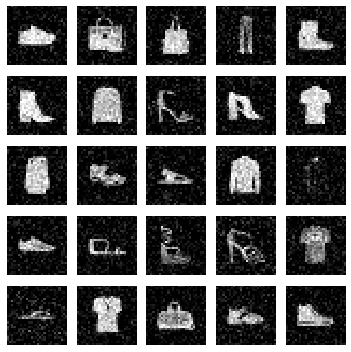

In [20]:
fig, axs = plt.subplots(rows,columns, figsize=(5, 5))
indx = -1
for i in range(rows):
    for j in range(columns):
        axs[i,j].imshow(X_train[indx], interpolation='nearest', cmap='gray')
        axs[i,j].axis('off')
        indx -= 1
plt.tight_layout()
plt.show()

# Machine Learning

### Build the Model
Next we build our convolutional neural network (CNN).
- It will take in an input image of 28 x 28 x 1
- We will use a relu activation function
- We will use drop out to minimize over fitting
- We will use batch normalization to make the network more stable
- We will output using a softmax activation function which will give the networks confidence that the input image match's a class

In [21]:
model = models.Sequential()

model.add(layers.Conv2D(32, 3, activation='relu', input_shape=(28,28, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Here we can see a visual representation of the model

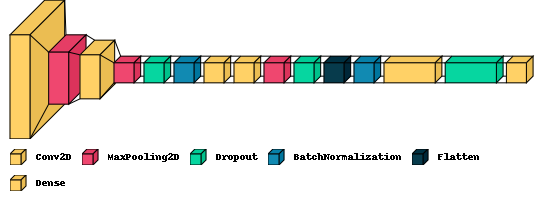

In [22]:
layered_view(model, legend=True)

### Training
Next is training:
- We will give the network an image, and it will make a prediction on what that image is.  We know what the image is because it is labeled, so we can use the labeled data to judge how well the network did, and adjust it so that future predictions are more accurate.
- We will process the images in batch sizes of 128, meaning we will judge how well the network did against the 128 images, and then adjust based on the average of the changes needed across the images.
- After the entire training set has been processed, we will then test the network on the test set to see how well it is performing on images it wasn't trained on.
- This process then repeats for the number of epochs specified.

We reach about 90% accuracy on the test data after 15 epochs.

In [23]:
history = model.fit(X_train, y_train, epochs=15,
                    batch_size = 128,
                    validation_data=(X_test, y_test))

Epoch 1/15
2813/2813 [==============================] - 319s 113ms/step - loss: 0.5182 - accuracy: 0.8067 - val_loss: 0.3514 - val_accuracy: 0.8660
Epoch 2/15
2813/2813 [==============================] - 323s 115ms/step - loss: 0.3886 - accuracy: 0.8557 - val_loss: 0.3243 - val_accuracy: 0.8777
Epoch 3/15
2813/2813 [==============================] - 323s 115ms/step - loss: 0.3547 - accuracy: 0.8681 - val_loss: 0.3104 - val_accuracy: 0.8847
Epoch 4/15
2813/2813 [==============================] - 325s 115ms/step - loss: 0.3373 - accuracy: 0.8748 - val_loss: 0.3141 - val_accuracy: 0.8839
Epoch 5/15
2813/2813 [==============================] - 325s 115ms/step - loss: 0.3244 - accuracy: 0.8794 - val_loss: 0.2940 - val_accuracy: 0.8843
Epoch 6/15
2813/2813 [==============================] - 326s 116ms/step - loss: 0.3138 - accuracy: 0.8831 - val_loss: 0.2858 - val_accuracy: 0.8929
Epoch 7/15
2813/2813 [==============================] - 327s 116ms/step - loss: 0.3067 - accuracy: 0.8852 - val_

# Analyze Performance
### Accuracy and Loss

Accuracy refers to how well the model is able to predict the correct label for the image.  The higher the score the better.

Loss refers to the magnitude of the mistakes the network is making.  Even if the network classifies the picture correctly, the probability of the output may have been uncertain.

While training the network, we want to see accuracy increase, and loss decrease.  We will plot the history to see how the model is improving over time.  There are two views of accuracy and loss, the metrics against the training set, and the metrics against the testing set.

The model has stable accuracy and loss curves, and they do not seem to have flattened it may be able to improve more with further training, but it will be slow at this point forward.

In [24]:
history.history

{'loss': [0.5181991457939148,
  0.3886125385761261,
  0.35467880964279175,
  0.3373037576675415,
  0.3244059979915619,
  0.31382670998573303,
  0.30671462416648865,
  0.30025556683540344,
  0.2952450215816498,
  0.2906646132469177,
  0.28553926944732666,
  0.2820500135421753,
  0.2768915891647339,
  0.27451270818710327,
  0.2700991630554199],
 'accuracy': [0.8067305684089661,
  0.8556944727897644,
  0.8681361079216003,
  0.8748139142990112,
  0.8793777823448181,
  0.8831194639205933,
  0.885158360004425,
  0.8882083296775818,
  0.8897305727005005,
  0.8918555378913879,
  0.8926555514335632,
  0.8941472172737122,
  0.8958916664123535,
  0.8972416520118713,
  0.8988694548606873],
 'val_loss': [0.3514115512371063,
  0.3243483603000641,
  0.3103629946708679,
  0.31410661339759827,
  0.29395565390586853,
  0.285769522190094,
  0.2827671468257904,
  0.2863302528858185,
  0.2772426903247833,
  0.27401068806648254,
  0.26595231890678406,
  0.27413231134414673,
  0.26968273520469666,
  0.282656

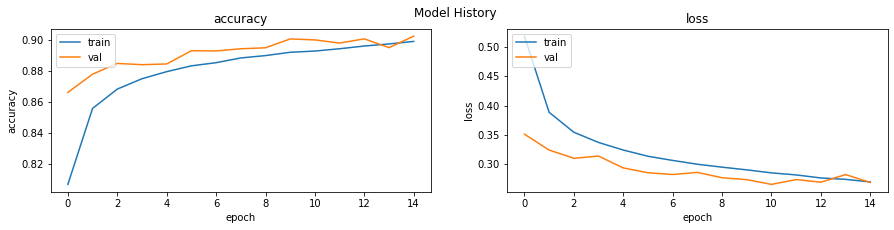

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
fig.suptitle('Model History')

plot_labels = ['accuracy', 'loss']

for i, label in enumerate(plot_labels):
    ax[i].plot(history.history[label])
    ax[i].plot(history.history[f'val_{label}'])
    ax[i].set_title(label)
    ax[i].set_ylabel(label)
    ax[i].set_xlabel('epoch')
    ax[i].legend(['train', 'val'], loc='upper left')

plt.show()

### Confusion Matrix

We will use a confusion matrix to play the results of the network on the test set.
- The X axis shows what the correct class was
- The Y axis shows what the model predicted.
- When the model predicts the correct class, it will show up in the diagonal
- When the model predicts the wrong class, we can see what it thought the image was, versus what is actually was
- We can use this to see what classes the model is struggling to identify

Looking at the results of the model:
- The biggest misclassifications are between Shirts and T-Shirts/Tops, which is understandable since they are very similar items
- There is some confusion between different tops (Coats, Shirts, Pullovers, etc.)
- There is some confusion between different footwear (Sandals, Sneakers, Ankle Boots)

Overall the model performs well, and should be good for use!

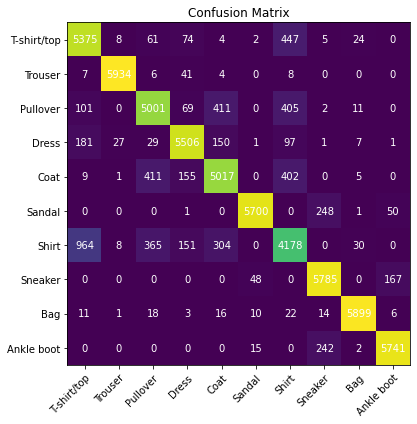

In [26]:
cm = confusion_matrix(y_true = np.argmax(y_test, axis = 1),
                      y_pred = np.argmax(model.predict(X_test), axis = 1))
                      
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)


# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

### Testing with real world examples
Now we will load some real images, process them into a format the the network can read, and do a sanity check to see if the model can perform on real world data 

In [31]:
def process_image(image):
    # pad image to be square
    image = image.convert('L') # convert to black and white
    background = int(np.argmax(np.bincount(np.array(image).flatten())))
    width, height = image.size
    if width == height:
        square = image
    elif width > height:
        square = Image.new(image.mode, (width, width), (background))
        square.paste(image, (0, (width - height) // 2))
    else:
        square = Image.new(image.mode, (height, height), (background))
        square.paste(image, ((height - width) // 2, 0))
    image = square

    image = image.resize((28,28)) # resize to 28 by 28

    image = invert(image) # invert color

    image = np.array(image) # convert to numpy array
    image = image - image.min() # maximize contrast
    image = image / image.max() # normalize values to be between 0 and 1
    image = np.reshape(image, (1, 28, 28, 1)) # reshape

    return image

#### Pullover
The model predicts the correct class!

Pullover


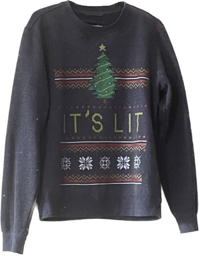

T-shirt/top: 0.01%
Trouser: 0.0%
Pullover: 82.78%
Dress: 0.0%
Coat: 5.2%
Sandal: 0.0%
Shirt: 12.01%
Sneaker: 0.0%
Bag: 0.0%
Ankle boot: 0.0%


In [32]:
image = Image.open('data/pullover.jpg')
processed_image = process_image(image)
pred = model.predict(processed_image)[0]
print(labels[pred.argmax()])
ar = image.height / image.width
size = 200
display(image.resize((size,int(size*ar))))
for i, confidence in enumerate(pred):
    print('{}: {}%'.format(labels[i], round(confidence*100,2)))

#### Ankle Boot
The model predicts the correct class!

Ankle boot


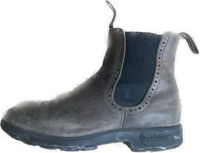

T-shirt/top: 0.0%
Trouser: 0.0%
Pullover: 0.0%
Dress: 0.0%
Coat: 0.0%
Sandal: 0.0%
Shirt: 0.0%
Sneaker: 0.26%
Bag: 0.0%
Ankle boot: 99.74%


In [29]:
image = Image.open('data/boot.jpg')
processed_image = process_image(image)
pred = model.predict(processed_image)[0]
print(labels[pred.argmax()])
ar = image.height / image.width
size = 200
display(image.resize((size,int(size*ar))))
for i, confidence in enumerate(pred):
    print('{}: {}%'.format(labels[i], round(confidence*100,2)))

# Export the Model
The model performs well, and is ready to be deployed.

Because the model will not be retrieving any more training, we will freeze it, and convert it to a .tflite format.  This will decrease the file size, and increase its performance.  This will help us when deploying it to the cloud.

In [30]:
model.save('model')
converter = tf.lite.TFLiteConverter.from_saved_model('model')
tflite_model = converter.convert()

with open('../API/model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: model\assets
